In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

In [2]:
%%writefile rock_agent.py

def rock_agent(observation, configuration):
    return 0

Overwriting rock_agent.py


In [3]:
%%writefile paper_agent.py

def paper_agent(observation, configuration):
    return 1

Overwriting paper_agent.py


In [4]:
%%writefile scissors_agent.py

def scissors_agent(observation, configuration):
    return 2

Overwriting scissors_agent.py


In [5]:
%%writefile nash_equilibrium.py
import random

def nash_equilibrium_agent(observation, configuration):
    return random.randint(0, 2)

Overwriting nash_equilibrium.py


In [6]:
%%writefile mirror_opponent.py

def mirror_opponent_agent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return 0

Overwriting mirror_opponent.py


In [7]:
%%writefile mirror_shift_opponent_1.py

def mirror_shift_opponent_agent_1(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 0 

Overwriting mirror_shift_opponent_1.py


In [8]:
%%writefile mirror_shift_opponent_2.py

def mirror_shift_opponent_agent_2(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % 3
    else:
        return 0

Overwriting mirror_shift_opponent_2.py


In [9]:
%%writefile mirror_shift_1.py

def mirror_shift_agent_1(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 0 

Overwriting mirror_shift_1.py


In [10]:
%%writefile mirror_shift_2.py

def mirror_shift_agent_2(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % 3
    else:
        return 0 

Overwriting mirror_shift_2.py


In [11]:
%%writefile transition_matrix.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# action_opponent_1 : action of the opponent with 1 step before
# action_opponent_2 : action of the opponent with 2 steps before

action_opponent_1, action_opponent_2 = None, None

def transition_matrix_agent(observation, configuration):
    global T, P, action_opponent_1, action_opponent_2
    if observation.step > 1:
        action_opponent_1 = observation.lastOpponentAction
        T[action_opponent_2, action_opponent_1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        action_opponent_2 = action_opponent_1
        if np.sum(P[action_opponent_1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[action_opponent_1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))

    else:
        if observation.step == 1:
            action_opponent_2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting transition_matrix.py


In [12]:
%%writefile statistical.py
action_histogram = {}


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


In [13]:
list_names = [
    'rock_agent',
    'paper_agent',
    'scissors_agent',
    'nash_equilibrium',
    'mirror_opponent',
    'mirror_shift_1',
    'mirror_shift_2',
    'mirror_shift_opponent_1',
    'mirror_shift_opponent_2',
    'transition_matrix',
    'statistical',
    ]


n_agents = len(list_names)

list_agents = [agent_name + ".py" for agent_name in list_names]
scores = np.zeros((n_agents, n_agents), dtype=np.int64)

In [14]:
print("Simulation of battles. It can take some time...")

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(
            f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}", 
            end="\r"
        )
        
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 1000}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]
    
    print()

Simulation of battles. It can take some time...
LOG: rock_agent vs statisticalmatrixnent_2
LOG: paper_agent vs statisticalmatrixnent_2
LOG: scissors_agent vs statisticalmatrixnent_2
LOG: nash_equilibrium vs statisticalmatrixnent_2
LOG: mirror_opponent vs statisticalmatrixnent_2
LOG: mirror_shift_1 vs statisticalmatrixnent_2
LOG: mirror_shift_2 vs statisticalmatrixnent_2
LOG: mirror_shift_opponent_1 vs statisticalmatrixnent_2
LOG: mirror_shift_opponent_2 vs statisticalmatrix
LOG: transition_matrix vs statistical



(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'rock_agent'),
  Text(0, 1.5, 'paper_agent'),
  Text(0, 2.5, 'scissors_agent'),
  Text(0, 3.5, 'nash_equilibrium'),
  Text(0, 4.5, 'mirror_opponent'),
  Text(0, 5.5, 'mirror_shift_1'),
  Text(0, 6.5, 'mirror_shift_2'),
  Text(0, 7.5, 'mirror_shift_opponent_1'),
  Text(0, 8.5, 'mirror_shift_opponent_2'),
  Text(0, 9.5, 'transition_matrix'),
  Text(0, 10.5, 'statistical')])

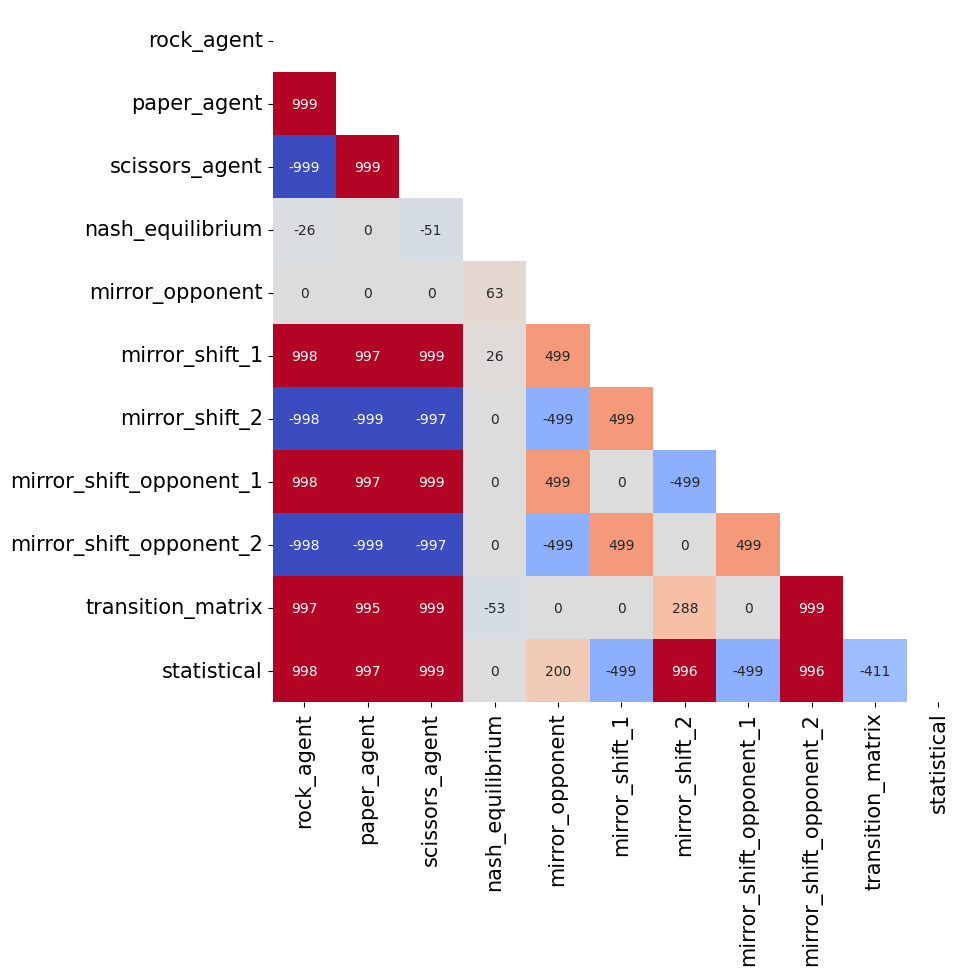

In [17]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)

mask = np.triu(np.ones_like(df_scores))

plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', fmt="d",
    mask=mask,
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)